In [11]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as spopt
import scipy.fftpack as spfft
import cvxpy as cvx
import cv2

In [12]:
def dct2(x):
    return spfft.dct(spfft.dct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

def idct2(x):
    return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

In [13]:
# read original image and downsize for speed
x = cv2.imread('imgs/pixcat2.png', 0)
ny,nx = x.shape
print(f"The shape of x: ({ny}, {nx})")

The shape of x: (160, 160)


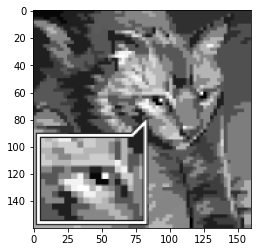

In [14]:
# show original image
plt.imshow(x, cmap='gray')
plt.show()

In [15]:
# extract small sample of signal
sample_rate = 0.3
k = round(nx * ny * sample_rate)
flt = np.sort(np.random.choice(nx * ny, k, replace=False))       # filter for y
print(flt)
y = x.T.flat[flt]

x_copy = x.flat.copy()
for i in range(len(x_copy)):
    if i not in flt:
        x_copy[i] = 255

print(f"The size of y: {y.shape}")

[    0     9    10 ... 25591 25598 25599]
The size of y: (7680,)


In [16]:
msx = spfft.idct(np.identity(nx), norm='ortho', axis=0)
msy = spfft.idct(np.identity(ny), norm='ortho', axis=0)
# Theta = np.kron(msx, msy)[flt, :]
Theta = np.zeros((y.shape[0], nx * ny))
fit = 0
for i, ft in enumerate(flt):
    Theta[i] = np.kron(msx[ft // ny], msy[ft % ny])
print(Theta.shape)

(7680, 25600)


In [17]:
# do L1 optimization
vx = cvx.Variable(nx * ny)
objective = cvx.Minimize(cvx.norm(vx, 1))
constraints = [Theta @ vx == y]
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=True, solver='OSQP')
Xat2 = np.array(vx.value).squeeze()

                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Mar 01 01:06:15 PM: Your problem has 25600 variables, 1 constraints, and 0 parameters.
(CVXPY) Mar 01 01:06:15 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 01 01:06:15 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 01 01:06:15 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 01 01:06:15 PM: Compiling problem (target solver=OSQP).
(CVXPY) Mar 01 01:06:15 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuff

sparsity (0-elems) : 0.0002734375


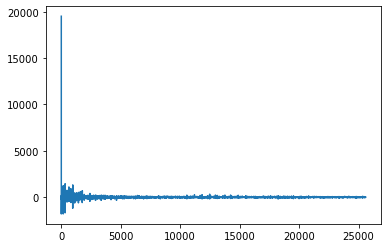

In [18]:
plt.plot(Xat2)
for i, m in enumerate(Xat2):
    if abs(m) < 1e-5: Xat2[i] = 0
print(f"sparsity (0-elems) : {len(Xat2[Xat2 == 0]) / len(Xat2)}")

(160, 160)


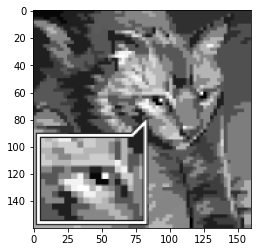

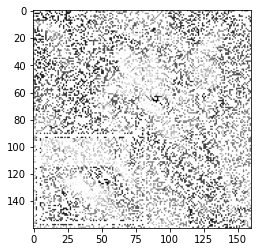

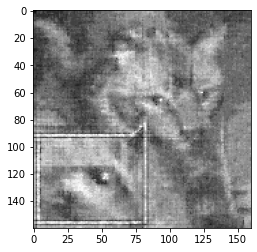

In [19]:
# reconstruct signal
Xat = Xat2.reshape(nx, ny).T
Xa = idct2(Xat)
print(Xa.shape)

plt.imshow(x, cmap='gray')
plt.show()
plt.imshow(x_copy.reshape(ny, nx), cmap='gray')
plt.show()
plt.imshow(Xa, cmap='gray')
plt.show()

In [20]:
# compare the similarity between two images

import sewar

def metrics(origin, recover):
    # smaller means more similar
    print("MSE: ",      sewar.mse(origin,recover))
    print("RMSE: ",     sewar.rmse(origin, recover))
    # bigger means more similar
    print("PSNR: ",     sewar.psnr(origin, recover))
    print("SSIM: ",     sewar.ssim(origin, recover))
    print("UQI: ",      sewar.uqi(origin, recover))

metrics(x, Xa.astype(np.uint8))

MSE:  526.9148046875
RMSE:  22.954624908447098
PSNR:  20.913399597827652
SSIM:  (0.7098157604196391, 0.7105322479656982)
UQI:  0.9799427947840728
